# Module 07: K-Nearest Neighbors

## Prerequisites

In [2]:
# Helper packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *

# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence

In [3]:
# diabetes data
pima = pd.read_csv("../../00-data/ML/pima.csv")

# recode response variable to 1/0
pima = pima.replace({"diabetes": {"pos": 1, "neg": 0}})

# create train/test split
train, test = train_test_split(pima, train_size=0.7, random_state=123)

# separate features from labels and only use numeric features
X_train = train.drop("diabetes", axis=1)
y_train = train[["diabetes"]].values.ravel()

## Fitting a KNN model

In [4]:
# Center and scale (i.e., standardize) all numeric features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

# create KNN model object
knn = KNeighborsClassifier(n_neighbors=5)

# define loss function
loss = 'roc_auc'

# create 5 fold CV object
kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# fit model with 5-fold CV
results = cross_val_score(knn, X_train_std, y_train, cv=kfold, scoring=loss)


np.round(results, 3)

array([0.714, 0.8  , 0.746, 0.744, 0.699])

## Tuning

In [5]:
# create KNN model object
knn = KNeighborsClassifier()

# Create grid of hyperparameter values
hyper_grid = {'n_neighbors': range(1, 101, 4)}

# Tune a knn model using grid search
grid_search = GridSearchCV(knn, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train_std, y_train)

# Best model's cross validated RMSE
abs(results.best_score_)

0.7937925335499548

In [6]:
# Best model's k value
optimal_k = results.best_estimator_.get_params().get('n_neighbors')
optimal_k

85

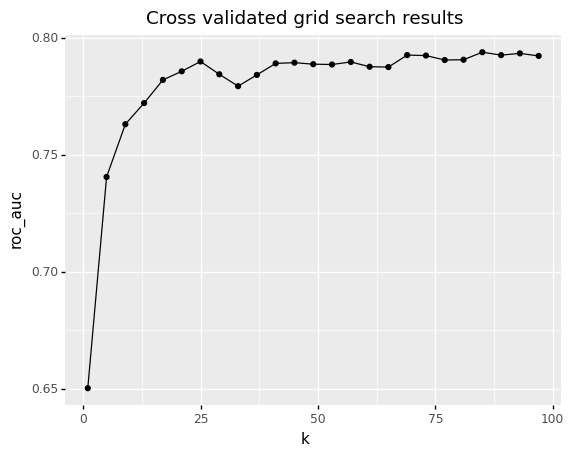

<ggplot: (319695773)>

In [7]:
# Plot all RMSE results
all_errors = pd.DataFrame({
  'k': range(1, 101, 4),
  'roc_auc': results.cv_results_['mean_test_score']
  })

(ggplot(all_errors, aes(x='k', y='roc_auc'))
 + geom_line()
 + geom_point()
 + ggtitle("Cross validated grid search results"))

## Model performance

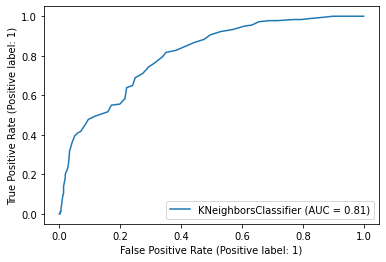

In [8]:
# best model
knn_best = KNeighborsClassifier(n_neighbors=optimal_k)
knn_best_fit = knn_best.fit(X_train_std, y_train)

# create ROC curve
plot_roc_curve(knn_best_fit, X_train_std, y_train)  
plt.show()

In [9]:
predictions = knn_best_fit.predict(X_train_std)
cm = confusion_matrix(y_train, predictions)
cm

array([[346,  11],
       [133,  47]])

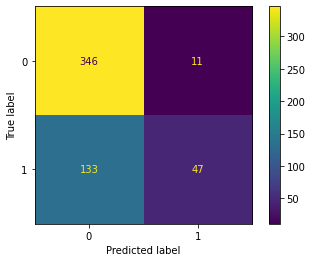

In [10]:
disp = ConfusionMatrixDisplay(
  confusion_matrix=cm,
  display_labels=knn_best_fit.classes_
  )
  
disp.plot()

In [11]:
print(classification_report(y_train, predictions, target_names=["neg", "pos"]))

              precision    recall  f1-score   support

         neg       0.72      0.97      0.83       357
         pos       0.81      0.26      0.39       180

    accuracy                           0.73       537
   macro avg       0.77      0.62      0.61       537
weighted avg       0.75      0.73      0.68       537



## Feature interpretation

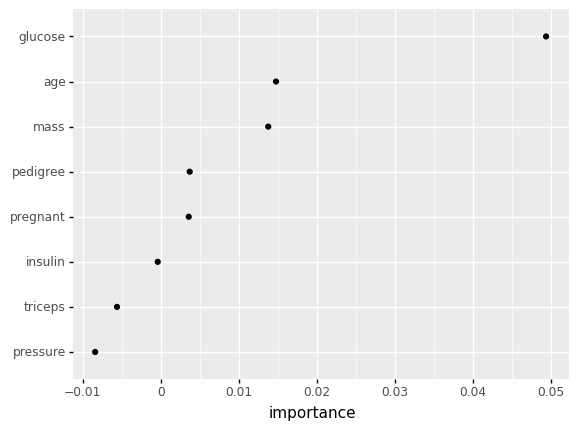

<ggplot: (319868925)>

In [12]:
r = permutation_importance(
  knn_best_fit, 
  X_train_std, 
  y_train,
  n_repeats=30,
  random_state=0
  )
  
vip = pd.DataFrame({'feature': X_train.columns.values,
                    'importance': r.importances_mean})
                    
(ggplot(vip, aes('importance', 'reorder(feature, importance)'))
  + geom_point()
  + labs(y=None))

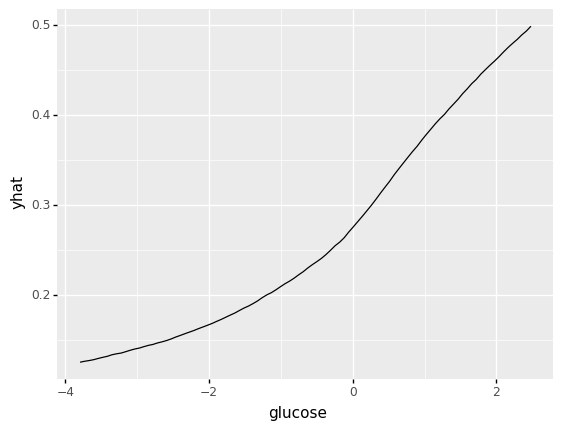

<ggplot: (319928278)>

In [13]:
pd_results = partial_dependence(
  knn_best_fit, X_train_std, features=1, kind='average',
  percentiles=(0, 1)
) 
  
pd_output = pd.DataFrame({'glucose': pd_results['values'][0],
                          'yhat': pd_results['average'][0]})
                          
(ggplot(pd_output, aes('glucose', 'yhat'))
  + geom_line())

## Exercises

Using the `hitters` dataset where the `Salary` variable is the response variable:

1. Apply a KNN model with all features. Use a grid search to assess values of _k_ ranging from 1-99 that seeks to optimize the "RMSE" metric.
2. Plot the grid search performance.
3. What value for _K_ optimizes model performance? What does this tell you about your data?
4. Which 10 features are considered most influential? 
5. Plot the relationship between the most influential feature and the predicted salary values.